

## Now we will forecast demand for a given latitude-longitude`

### `Metric: RMSE, how close we are able to predict ride demand to true value`


In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [6]:
df = pd.read_csv('./Data/Data_Prepared.csv', compression = 'gzip')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              878400 non-null  object 
 1   pickup_cluster  878400 non-null  int64  
 2   request_count   878400 non-null  float64
 3   mins            878400 non-null  int64  
 4   hour            878400 non-null  int64  
 5   day             878400 non-null  int64  
 6   month           878400 non-null  int64  
 7   dayofweek       878400 non-null  int64  
 8   quarter         878400 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 60.3+ MB


In [8]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')
df.ts = pd.to_datetime(df.ts)
df.head(10)

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1
5,2020-03-26 02:30:00,0,0,30,2,26,3,3,1
6,2020-03-26 03:00:00,0,0,0,3,26,3,3,1
7,2020-03-26 03:30:00,0,0,30,3,26,3,3,1
8,2020-03-26 04:00:00,0,0,0,4,26,3,3,1
9,2020-03-26 04:30:00,0,0,30,4,26,3,3,1


In [9]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [10]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,2
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2
878397,2021-03-26 22:30:00,49,30,22,3,1,4,6
878398,2021-03-26 23:00:00,49,0,23,3,1,4,0


In [11]:
# First 24days of every month in Train and last 7 days of everymonth in Test
df_train = df[df.ts.dt.day <=23]
df_test = df[df.ts.dt.day >23]

In [12]:
len(df_train)

662400

In [13]:
len(df_test)

216000

In [14]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

In [15]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# Iteration: 1
Features: ['pickup_cluster','mins','hour','month','quarter','dayofweek']

In [16]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 6.357143528895982, RMSE TEST:6.289366827316246


### High Bais | Underfit
#### It is used to determine the extent to which there is a linear relationship between a dependent variable and one or more independent variables.
#### Moving to Ensemble Regressors: Bagging Algorithm Random Forest 
#### Random Forest Regressor: Random forests are bagged decision tree models that split on a subset of features on each split.
#### Give Feature importance based on target variable

In [17]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=42, n_jobs = -1, verbose=True)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    7.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    9.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.6s finished


RMSE TRAIN: 1.8990044939607205, RMSE TEST:4.121561955699205


In [18]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.348275
hour,0.292656
month,0.154055
quarter,0.100247
dayofweek,0.086621
mins,0.018146


### Random Forest Tend to Overfit

### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [19]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror", early_stopping_rounds=15,eval_metric="rmse")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set)
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.47642
[1]	validation_0-rmse:6.44626
[2]	validation_0-rmse:6.41696
[3]	validation_0-rmse:6.38818
[4]	validation_0-rmse:6.35955
[5]	validation_0-rmse:6.33150
[6]	validation_0-rmse:6.30350
[7]	validation_0-rmse:6.27644
[8]	validation_0-rmse:6.25000
[9]	validation_0-rmse:6.22431
[10]	validation_0-rmse:6.19818
[11]	validation_0-rmse:6.17352
[12]	validation_0-rmse:6.14926
[13]	validation_0-rmse:6.12434
[14]	validation_0-rmse:6.10091
[15]	validation_0-rmse:6.07685
[16]	validation_0-rmse:6.05403
[17]	validation_0-rmse:6.03095
[18]	validation_0-rmse:6.00790
[19]	validation_0-rmse:5.98571
[20]	validation_0-rmse:5.96446
[21]	validation_0-rmse:5.94311
[22]	validation_0-rmse:5.92154
[23]	validation_0-rmse:5.90060
[24]	validation_0-rmse:5.88059
[25]	validation_0-rmse:5.86036
[26]	validation_0-rmse:5.84062
[27]	validation_0-rmse:5.82073
[28]	validation_0-rmse:5.80134
[29]	validation_0-rmse:5.78276
[30]	validation_0-rmse:5.76285
[31]	validation_0-rmse:5.74555
[32]	validation_0-

In [20]:
dump(model,'./Model/prediction_model_without_lag.joblib',compress=3)

['./Model/prediction_model_without_lag.joblib']

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

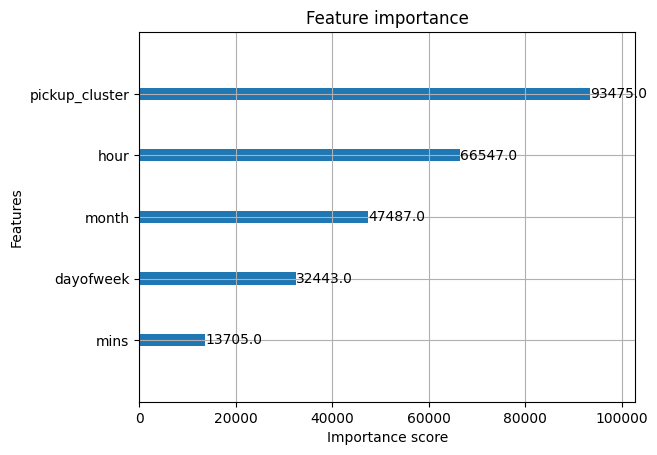

In [21]:
# plot feature importance
plot_importance(model)


# Iteration 2
Features: ['pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']

## Include: Lag Features

### If there is 30mins trend, how has ride requests been in last 1.5 hours. 
+ Hence testing with Lag Shift by 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.

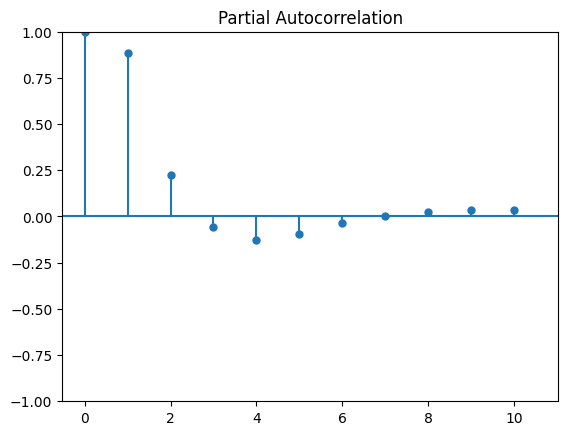

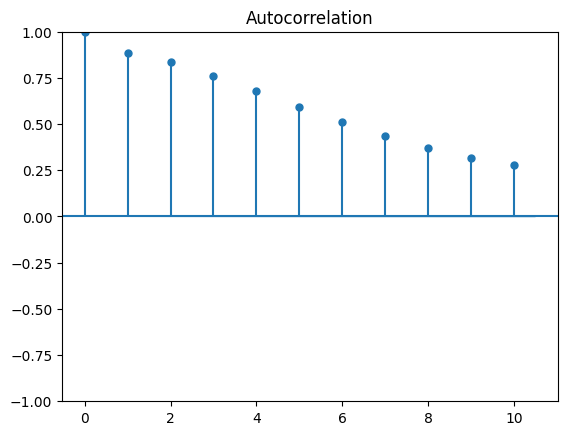

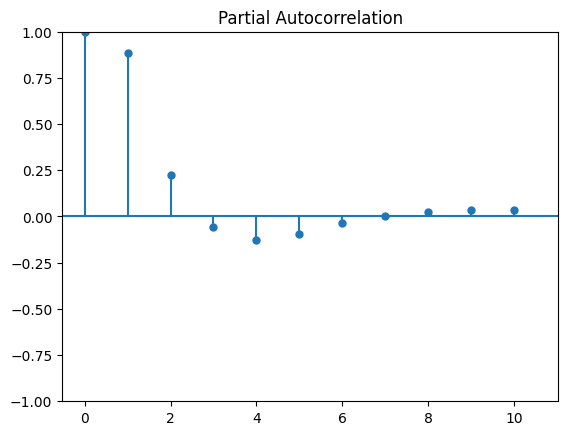

In [22]:
plot_acf(df_train['request_count'], lags=10)
plot_pacf(df_train['request_count'], lags=10)

The partial autocorrelation function shows a high correlation with the first two lag and lesser correlation with the 3rd and 4th lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [23]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp.head(15)

,,,,,,,request_count,lag_1,lag_2,lag_3
ts,pickup_cluster,mins,hour,month,quarter,dayofweek,,,,
2020-03-26 00:00:00,0,0,0,3,1,3,0,NaN,NaN,NaN
2020-03-26 00:30:00,0,30,0,3,1,3,0,0.0,NaN,NaN
2020-03-26 01:00:00,0,0,1,3,1,3,0,0.0,0.0,NaN
2020-03-26 01:30:00,0,30,1,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:30:00,0,30,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 04:00:00,0,0,4,3,1,3,0,0.0,0.0,0.0


In [24]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3',
        'request_count']]

In [25]:
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

In [26]:
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [27]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.9575364302196911, RMSE TEST:2.5532154420346553


In [28]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.791373
hour,0.046313
pickup_cluster,0.041379
lag_2,0.038768
lag_3,0.030041
dayofweek,0.020786
month,0.018669
mins,0.007961
quarter,0.004709


In [30]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror", early_stopping_rounds=30,eval_metric="rmse")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set)
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.45558
[1]	validation_0-rmse:6.40335
[2]	validation_0-rmse:6.35197
[3]	validation_0-rmse:6.30101
[4]	validation_0-rmse:6.25088
[5]	validation_0-rmse:6.20130
[6]	validation_0-rmse:6.15213
[7]	validation_0-rmse:6.10355
[8]	validation_0-rmse:6.05568
[9]	validation_0-rmse:6.00815
[10]	validation_0-rmse:5.96142
[11]	validation_0-rmse:5.91526
[12]	validation_0-rmse:5.86967
[13]	validation_0-rmse:5.82430
[14]	validation_0-rmse:5.77975
[15]	validation_0-rmse:5.73553
[16]	validation_0-rmse:5.69219
[17]	validation_0-rmse:5.64927
[18]	validation_0-rmse:5.60664
[19]	validation_0-rmse:5.56447
[20]	validation_0-rmse:5.52288
[21]	validation_0-rmse:5.48182
[22]	validation_0-rmse:5.44143
[23]	validation_0-rmse:5.40143
[24]	validation_0-rmse:5.36180
[25]	validation_0-rmse:5.32270
[26]	validation_0-rmse:5.28408
[27]	validation_0-rmse:5.24602
[28]	validation_0-rmse:5.20852
[29]	validation_0-rmse:5.17154
[30]	validation_0-rmse:5.13480
[31]	validation_0-rmse:5.09839
[32]	validation_0-

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

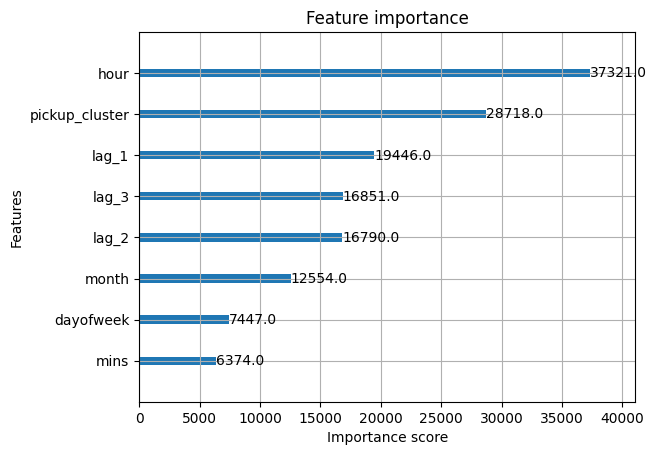

In [31]:
plot_importance(model)

### Xgboost perform better than random forest

<hr>

# Iteration3:
Features: ['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean']
## Include: Both Lag Features and Rolling Window
+ Both of size = 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.
<br>
rolling_mean: previous 3 days request_count mean

In [38]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(['pickup_cluster', 'ts'])  # Ensure it's sorted
temp = temp.set_index(['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp['rolling_mean'] = (
    temp.groupby('pickup_cluster')['request_count']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
    .reset_index(level=0, drop=True)
)




temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean','request_count']]
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

## Random Forest Overfits i.e. performs good on training dataset and bad on test dataset

In [42]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1500, max_depth=8, objective="reg:squarederror", early_stopping_rounds=20,eval_metric="rmse")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set)
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.45534
[1]	validation_0-rmse:6.40283
[2]	validation_0-rmse:6.35119
[3]	validation_0-rmse:6.29999
[4]	validation_0-rmse:6.24960
[5]	validation_0-rmse:6.19979
[6]	validation_0-rmse:6.15047
[7]	validation_0-rmse:6.10144
[8]	validation_0-rmse:6.05335
[9]	validation_0-rmse:6.00555
[10]	validation_0-rmse:5.95834
[11]	validation_0-rmse:5.91194
[12]	validation_0-rmse:5.86563
[13]	validation_0-rmse:5.82028
[14]	validation_0-rmse:5.77548
[15]	validation_0-rmse:5.73113
[16]	validation_0-rmse:5.68706
[17]	validation_0-rmse:5.64360
[18]	validation_0-rmse:5.60068
[19]	validation_0-rmse:5.55827
[20]	validation_0-rmse:5.51659
[21]	validation_0-rmse:5.47535
[22]	validation_0-rmse:5.43450
[23]	validation_0-rmse:5.39424
[24]	validation_0-rmse:5.35461
[25]	validation_0-rmse:5.31541
[26]	validation_0-rmse:5.27653
[27]	validation_0-rmse:5.23812
[28]	validation_0-rmse:5.20038
[29]	validation_0-rmse:5.16286
[30]	validation_0-rmse:5.12610
[31]	validation_0-rmse:5.08955
[32]	validation_0-

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

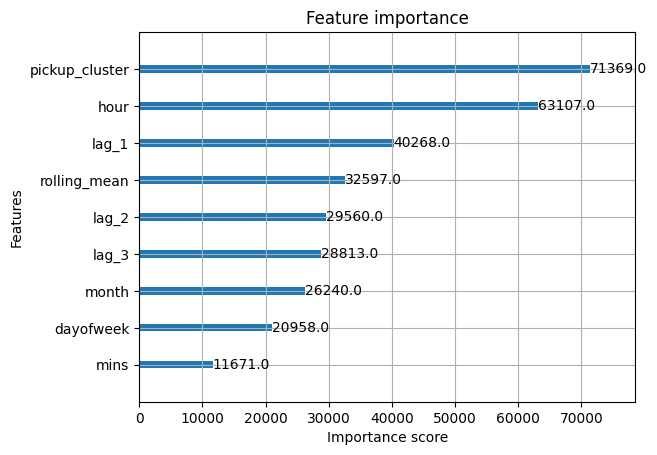

In [43]:
plot_importance(model)

In [45]:
dump(model,'./Model/prediction_model.joblib',compress=3)

['./Model/prediction_model.joblib']

### Comment: Lag Features and Rolling Mean has improved RMSE

<hr>

# Final Model: Iteration3
+ Good performance with feature addition

# Has Features: `['pickup_cluster','mins','hour','month','dayofweek','quarter', 'lag_1','lag_2','lag_3','rolling_mean']`

### Model Score: 0.91

In [47]:
model = load('./Model/prediction_model.joblib')

In [48]:
model.predict(X_test)

array([0.16529389, 0.12002576, 0.14513707, ..., 1.9610912 , 2.7149425 ,
       1.4518878 ], dtype=float32)